In [1]:
import os
import json
import pandas as pd
import calendar
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageFilter
import colorsys
import numpy as np
import math
from tqdm import tqdm
from IPython.display import display, clear_output
import shutil
import warnings

In [2]:
# Suppress DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# Load final streaming data df from pickle
final_streaming_data_df = pd.read_pickle('streaming_data_df.pkl')

In [4]:
# List of predefined vibrant gradients (not in use currently)
gradients = [
    ('#DB2763', '#B0DB43'), ('#E43D00', '#FFE900'), ('#E4F3E3', '#5CA9E9'),
    ('#BCE7FC', '#C491B1'), ('#D36135', '#80B069'), ('#350068', '#FF6978'),
    ('#022F40', '#38AECC'), ('#91F1EF', '#FFD5E0'), ('#264653', '#2A9D8F'),
    ('#505250', '#CBD3C1'), ('#51A3A3', '#75485E'), ('#DA3068', '#14469F'),
    ('#23CD6B', '#272D2D'), ('#7FB7BE', '#D2F3EE'), ('#EDAE48', '#D1495B'),
    ('#00C1D0', '#0A0F44'), ('#FCFB62', '#91F9E5'), ('#7B4C94', '#7D82B9'),
    ('#70C1B3', '#247B9F'), ('#C88284', '#F3D8DB'), ('#301847', '#C10214')
]

In [5]:
# Utility functions to convert RGB values
def generate_vibrant_color(used_colors, min_distance=100):
    """Generate a random vibrant color that is sufficiently different from used colors."""
    while True:
        h = random.random()
        s = random.uniform(0.7, 1.0)  # High saturation for vibrancy
        v = random.uniform(0.8, 1.0)  # High brightness for vibrancy
        color = tuple(int(i * 255) for i in colorsys.hsv_to_rgb(h, s, v))

        # Ensure the color is sufficiently different from used colors
        if all(calculate_color_distance(color, used_color) > min_distance for used_color in used_colors):
            return color

def calculate_color_distance(color1, color2):
    """Calculate the Euclidean distance between two colors."""
    return np.sqrt(sum((c1 - c2) ** 2 for c1, c2 in zip(color1, color2)))

# Function to generate a random vibrant and high-contrast color pair
def generate_color_pair(used_colors):
    while True:
        color1 = generate_vibrant_color(used_colors)
        color2 = generate_vibrant_color(used_colors)
        
        # Ensure the colors are sufficiently different in luminance and not similar to existing pairs
        lum_diff = abs(calculate_luminance(color1) - calculate_luminance(color2))
        if lum_diff > 80:  # Adjust the threshold as needed
            used_colors.extend([color1, color2])  # Add both colors to the used list
            return color1, color2

# Function to add radial gradient texture
def add_radial_gradient_texture(size, color1, color2):
    gradient_image = np.zeros((size[0], size[1], 3), dtype=np.float32)

    center_x, center_y = size[0] // 2, size[1] // 2
    max_radius = np.sqrt(center_x**2 + center_y**2)

    for y in range(size[1]):
        for x in range(size[0]):
            distance = np.sqrt((x - center_x)**2 + (y - center_y)**2)
            t = distance / max_radius
            for i in range(3):
                gradient_image[y, x, i] = (1 - t) * color1[i] + t * color2[i]

    gradient_image = np.clip(gradient_image, 0, 255).astype(np.uint8)

    # Add noise to the gradient to add texture
    noise_level = 25
    noise = np.random.normal(0, noise_level, size + (3,))
    noisy_image = np.clip(gradient_image + noise, 0, 255).astype(np.uint8)

    return Image.fromarray(noisy_image)

# Function to calculate luminance
def calculate_luminance(color):
    """Calculate the luminance of a color."""
    return 0.299 * color[0] + 0.587 * color[1] + 0.114 * color[2]

# Function to choose the text color
def choose_text_color(gradient_image):
    avg_luminance = np.mean(gradient_image.convert('L'))  # Convert to grayscale and take mean luminance
    return (255, 255, 255) if avg_luminance < 150 else (0, 0, 0)

In [6]:
# Function to create and display test images
def create_test_images(df, output_dir='test_covers'):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Image size (640x640 for Spotify cover)
    image_size = (640, 640)
    
    # Aggregate by year
    df_grouped = df.groupby(['year']).size().reset_index(name='count')
    
    # Dictionary to store gradients for each year
    year_gradients = {}

    used_colors = []

    font_file = "Paskowy.ttf"
    font = ImageFont.truetype(os.path.join(os.getcwd(),'fonts',font_file), 100)
  
    # Iterate through each row in the grouped DataFrame
    for index, row in df_grouped.iterrows():
        full_year = str(row['year'])
        text = f"Example {full_year}"
        
        # Generate a unique vibrant color pair for the year
        color1, color2 = generate_color_pair(used_colors)
        year_gradients[row['year']] = (color1, color2)
        
        # Use the generated gradient for the year
        background_img = add_radial_gradient_texture(image_size, color1, color2)
        
        # Add the full year as text for reference
        draw = ImageDraw.Draw(background_img)
        text_width, text_height = draw.textsize(text, font=font)
        position = ((image_size[0] - text_width) // 2, (image_size[1] - text_height) // 2)
        draw.text(position, text, font=font, fill=choose_text_color(background_img))
        
        # Save the test image
        filename = f"{output_dir}/{row['year']}_test.jpg"
        background_img.save(filename, format="JPEG", quality=50)
        
        # Display the image using plt
        plt.imshow(background_img)
        plt.axis('off')
        plt.show()
    
    return year_gradients

In [7]:
# Function to create final images
def create_final_images(df, year_gradients, output_dir='covers'):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Image size (640x640 for Spotify cover)
    image_size = (640, 640)
    
    # Imaginary box size and margin
    box_size = (560, 560)
    
    # Map month numbers to names
    month_mapping = {index: month for index, month in enumerate(calendar.month_name) if month}
    
    # Aggregate by year and month
    df_grouped = df.groupby(['year', 'month']).size().reset_index(name='count')

    # Get the current working directory
    current_dir = os.getcwd()

    # Construct the relative font path
    font_path = os.path.join(current_dir, "fonts", "Paskowy.ttf")
    
    # Check if the font path is correct
    if not os.path.exists(font_path):
        raise FileNotFoundError(f"Font file not found at: {font_path}")

    # Iterate through each row in the grouped DataFrame
    for index, row in tqdm(df_grouped.iterrows(), total=len(df_grouped), desc = 'Creating playlist covers'):
        # Convert month number to month name
        month_name = month_mapping[row['month']]
        # Abbreviate the month name for the text on the image
        month_name_abbrev = month_name[:3].upper()
        # Format the year as 'YY (e.g., '19)
        formatted_year = f"{str(row['year'])[-2:]}"
        text = f"{month_name_abbrev} {formatted_year}"
        
        # Use the assigned gradient for the year
        color1, color2 = year_gradients[row['year']]
        background_img = add_radial_gradient_texture(image_size, color1, color2)
        
        # Determine the best text color (black or white) based on background colors
        text_color = choose_text_color(background_img)
        
        # Initialize ImageDraw
        d = ImageDraw.Draw(background_img)
        
        # Load the custom font
        try:
            font = ImageFont.truetype(font_path, 10)  # Start with a small font size
        except IOError:
            raise IOError(f"Cannot load font from path: {font_path}")
        
        # Adjust font size to fit within the imaginary box
        max_font_size = 200  # Starting point for maximum font size
        while True:
            font = ImageFont.truetype(font_path, max_font_size)
            text_width, text_height = d.textsize(text, font=font)
            if text_width <= box_size[0] and text_height <= box_size[1]:
                break
            max_font_size -= 1  # Reduce font size if it doesn't fit
            
        # Calculate the position to center the text within the image
        position = ((image_size[0] - text_width) // 2, (image_size[1] - text_height) // 2)
        
        # Add text to the image using the chosen text color
        d.text(position, text, font=font, fill=text_color)
        
        # Save the image with the highest quality
        filename = f"{output_dir}/{row['year']}_{str(row['month']).zfill(2)}_{month_name_abbrev}.jpg"
        background_img.save(filename, format="JPEG", quality=100)

In [8]:
# Main function to execute the workflow
def main(df):
    year_gradients = create_test_images(df)
    proceed = input("Do you want to proceed with these combinations? (yes/no): ").strip().lower()

    if proceed == 'yes':
        create_final_images(df, year_gradients)
        shutil.rmtree('test_covers')
        print("Final images created.")
    else:
        shutil.rmtree('test_covers')
        print("Test images deleted. You can rerun the function to choose again.")

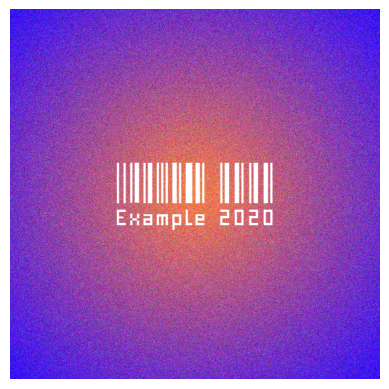

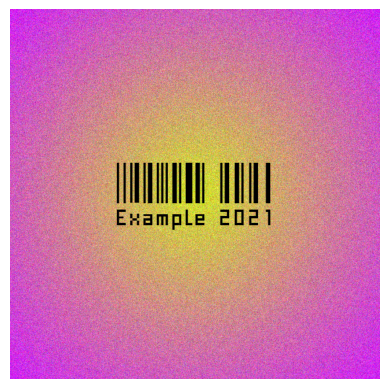

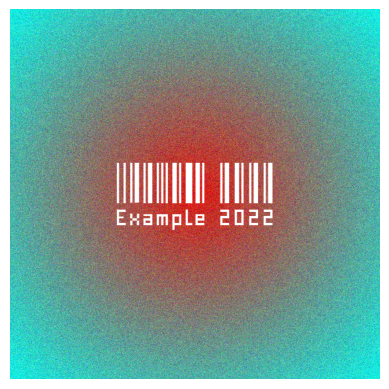

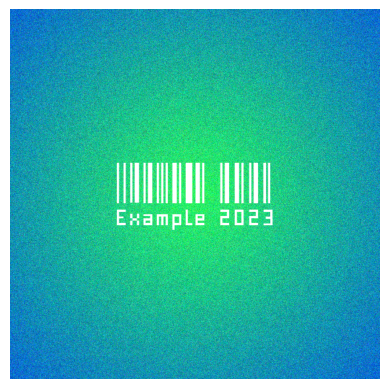

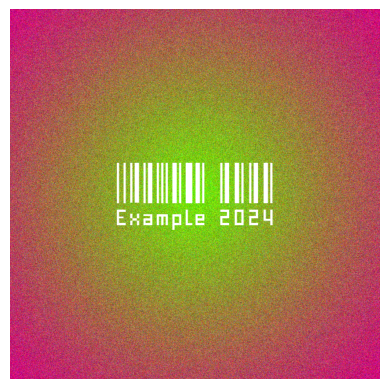

Do you want to proceed with these combinations? (yes/no): yes


Creating playlist covers: 100%|█████████████████| 53/53 [02:06<00:00,  2.39s/it]

Final images created.


In [9]:
main(final_streaming_data_df)